# EDA : EXPLORATORY DATA ANALAYSIS

In [9]:
#Quelques imports très utiles
import pandas as pd 
import matplotlib.pyplot as plt 
import os 
import seaborn as sns
from io import BytesIO
import base64

# **Table of Content:**

- #### [I. La pollution en France](#La_pollution_en_France)
- #### [II. Répartition de la population en France métropolitaine](#Répartition_pop)
- #### [III. Répartition des véhicules électriques en France métropolitaine](#Répartition_ve)

<a name='La_pollution_en_France'></a>

## **I. La pollution en France**

Lien vers le dataset : https://www.insee.fr/fr/statistiques/2015759

In [2]:
URL = "https://www.insee.fr/fr/statistiques/fichier/2015759/deve-envir-emissions-co2.xlsx"
df = pd.read_excel(URL)

# Rendre le dataframe lisible
def transform(dataset):
    colonnes = ['Émissions de gaz à effet de serre par activité'] + [ f'{i}' for i in range(1990,2023)]
    dataset.set_axis(colonnes, axis=1, inplace=True)
    dataset = dataset[3:11].reset_index()
    dataset.drop('index', axis=1, inplace = True)
    return dataset
df = transform(df)
df.head()

,Émissions de gaz à effet de serre par activité,1990,1991,1992,1993,1994,1995,1996,1997,1998,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Industrie de l’énergie,78.851202,80.089495,81.357832,69.065977,65.973570,68.502396,72.081708,67.707550,80.069139,...,60.838441,47.198489,49.956407,53.546045,57.306330,47.982937,46.237280,41.266444,42.490917,44.575656
1,Industrie manufacturière et construction,139.412357,151.891836,139.881424,134.659609,135.640506,136.156076,138.341342,137.138262,131.172430,...,88.703973,86.003308,83.687003,83.202542,82.886590,82.798769,79.778832,72.046643,77.952643,72.973903
2,Traitement centralisé des déchets,15.770500,16.468496,17.264753,18.042975,18.419108,18.651170,18.695998,18.681612,19.112439,...,16.672992,16.007408,14.990339,15.011350,15.092677,14.821750,16.019293,15.927553,15.208793,15.177475
3,Usage des bâtiments et activités résidentiels/...,93.260689,102.932198,99.120231,95.513850,89.059078,88.948882,98.907077,94.048578,98.784997,...,98.034366,81.848655,84.846037,84.777680,84.062820,79.047162,76.038243,71.317465,75.090141,64.024935
4,Agriculture/sylviculture,88.297176,87.390855,87.067203,85.916454,85.034512,85.708999,86.605312,86.666545,86.890664,...,81.963010,83.494725,83.110580,81.690808,81.314373,80.438064,78.615927,78.244410,76.506548,76.524915


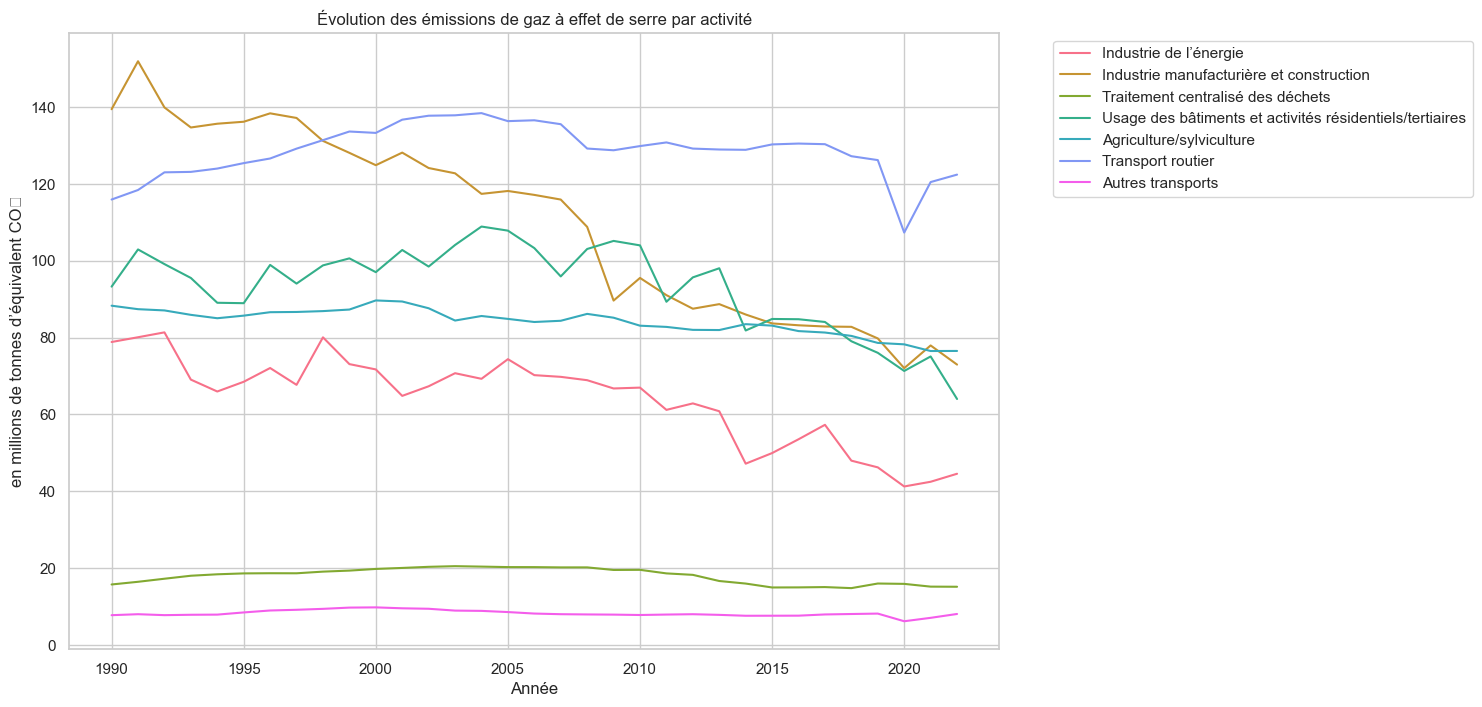

<Figure size 640x480 with 0 Axes>

In [10]:
# Tracer l'évolution 
plt.figure(figsize=(12,8))
sns.set(style="whitegrid")
palette = sns.color_palette("husl", n_colors=7)
colonnes = df.columns.to_list()[1:]
colonnes_int = [int(x) for x in colonnes]

for i in df.index.to_list():
    if i<7:
        nom = df['Émissions de gaz à effet de serre par activité'][i]
        evol = [df[col][i] for col in colonnes]
        #evol = df[colonnes][i:i+1].values
        plt.plot(colonnes_int, evol, label = f'{nom}', color = palette[i])
    else:
        pass
plt.xlabel('Année')
plt.ylabel('en millions de tonnes d’équivalent CO₂')
plt.title('Évolution des émissions de gaz à effet de serre par activité')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
img_data = BytesIO()  # Conversion du graphique en image base64
plt.savefig(img_data, format='png')
img_data.seek(0)
img_base64 = base64.b64encode(img_data.read()).decode()
graph_html = f'<img src="data:image/png;base64,{img_base64}" alt="Graphique d\'autonomie">'  #conserver le graphique sous format html pour le site

### Les facteurs d’émissions des différents modes de transport routier en Europe

Lien vers le site : https://www.data.gouv.fr/fr/datasets/etude-facteurs-demissions-des-differents-modes-de-transport-routier/

> Ce jeu de données est issu de la base de données européenne HBEFA v4.1 (Handbook of emissions factors for Road Transport) qui fournit des facteurs d’émissions, c’est-à-dire des émissions de polluants en g/km pour toutes les catégories de véhicules routiers (voiture particulière, véhicule utilitaire léger, véhicule lourd et deux-roues motorisé), chacune étant divisée en plusieurs sous-catégories, pour une grande variété de situations de trafic (type de voirie, vitesse limite et niveau de saturation du trafic associé). Les données extraites sont des facteurs d’émissions agrégés de CO, HC, NOx et particules par catégorie de véhicules (voiture, véhicule utilitaire léger, poids lourd, autocar, bus et deux roues motorisées), par carburant (essence, gazole et GNV uniquement pour les bus), pour des conditions de circulation moyennes (urbain, rural et mixte France) et pour chaque année allant de 2020 à 2030.

In [11]:
URL = 'https://www.data.gouv.fr/fr/datasets/r/3e00d056-13ef-4069-b7bb-045859750a90'
df = pd.read_csv(URL)

In [12]:
print(df['Véhicule'].unique())
print(df.columns.to_list())

['2RM' 'PL' 'Autocar' 'Bus' 'Voiture' 'VUL']
['Année', 'Véhicule', 'Carburant', 'Roulage', 'CO (g/km)', 'HC (g/km)', 'NOx (g/km)', 'Particules (g/km)']


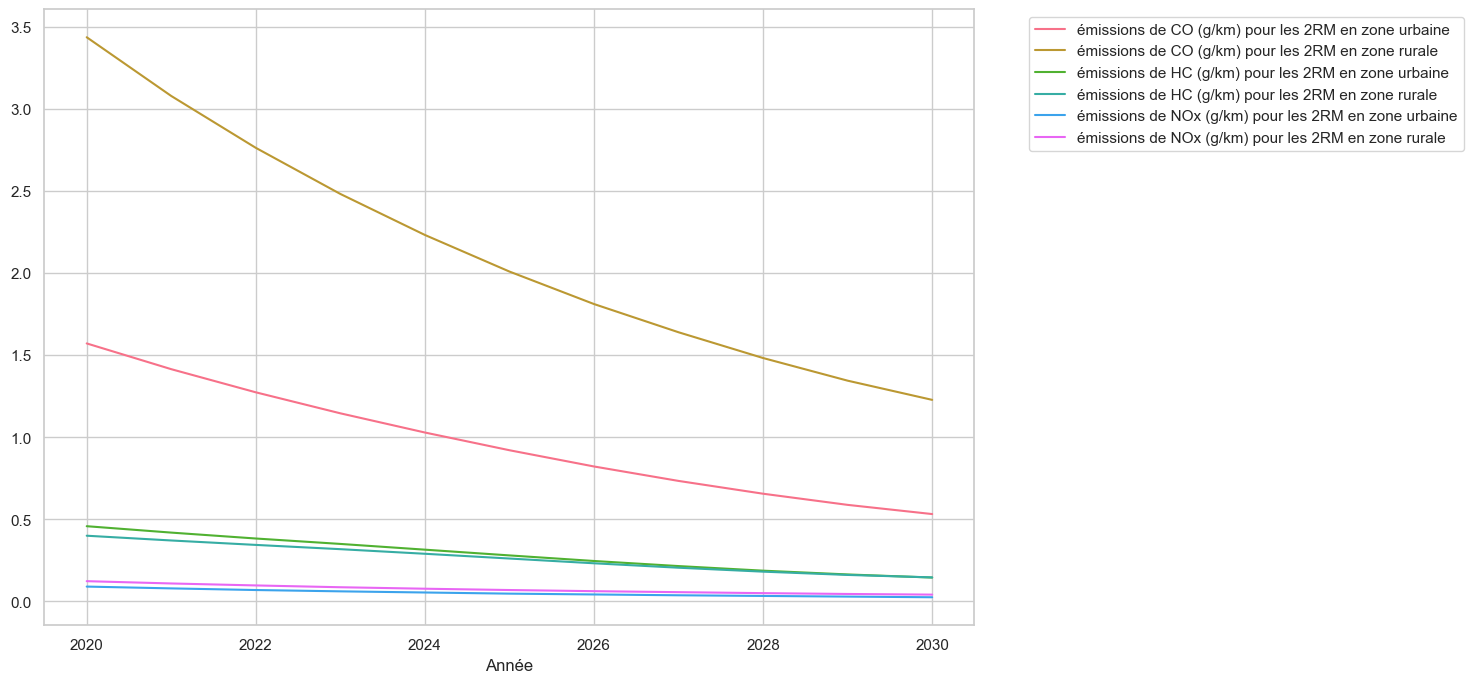

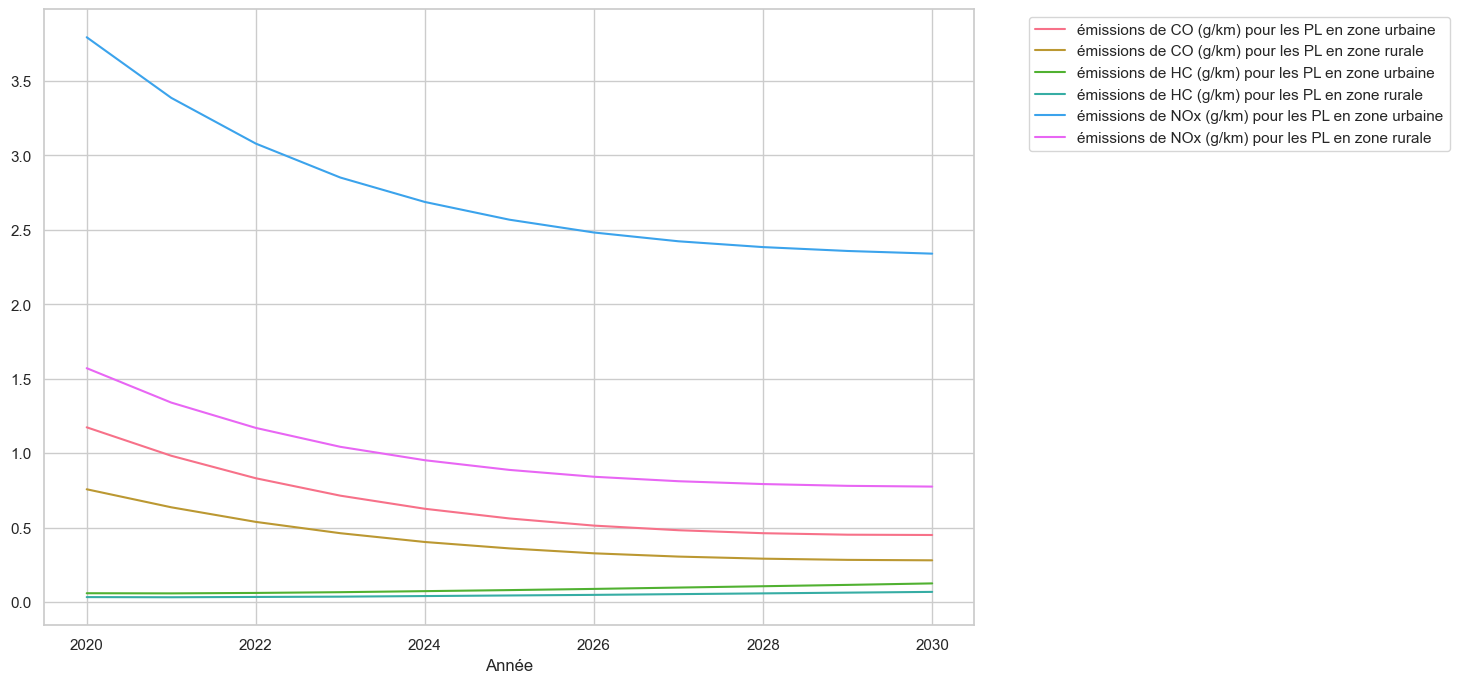

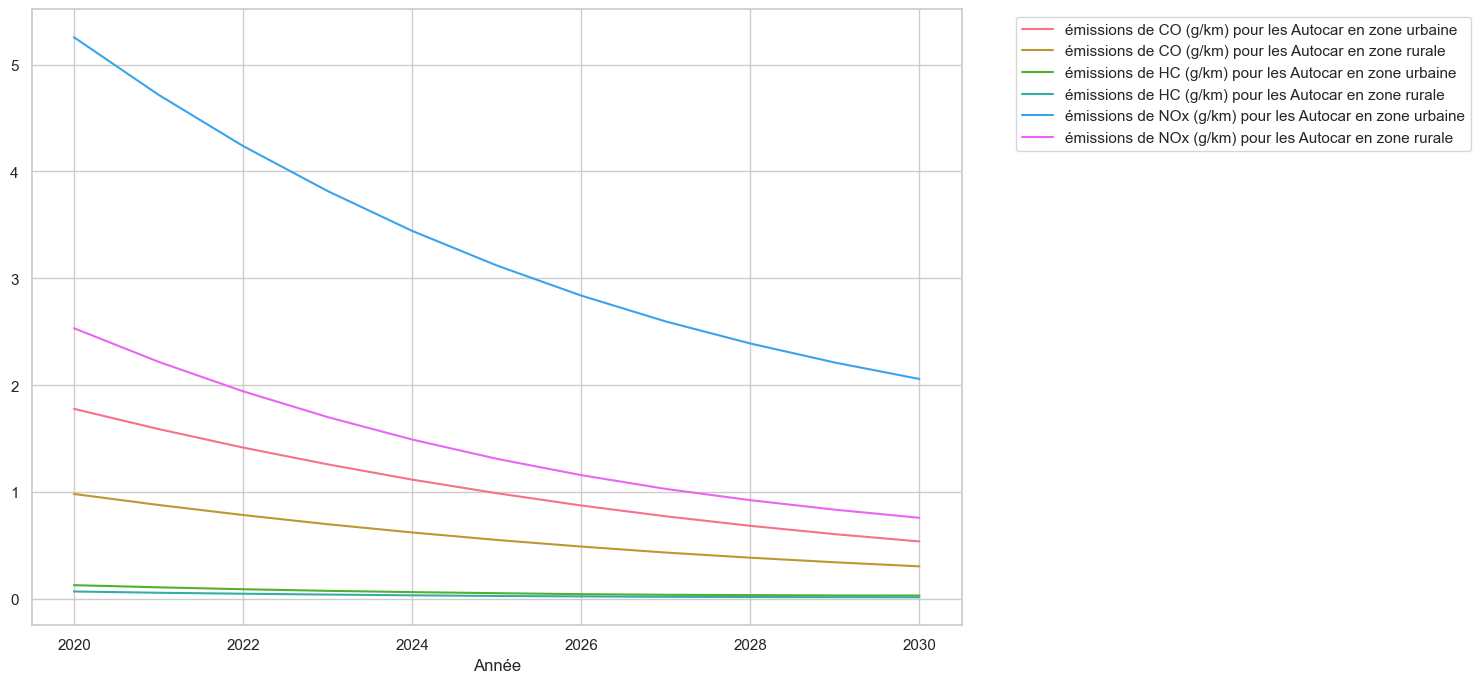

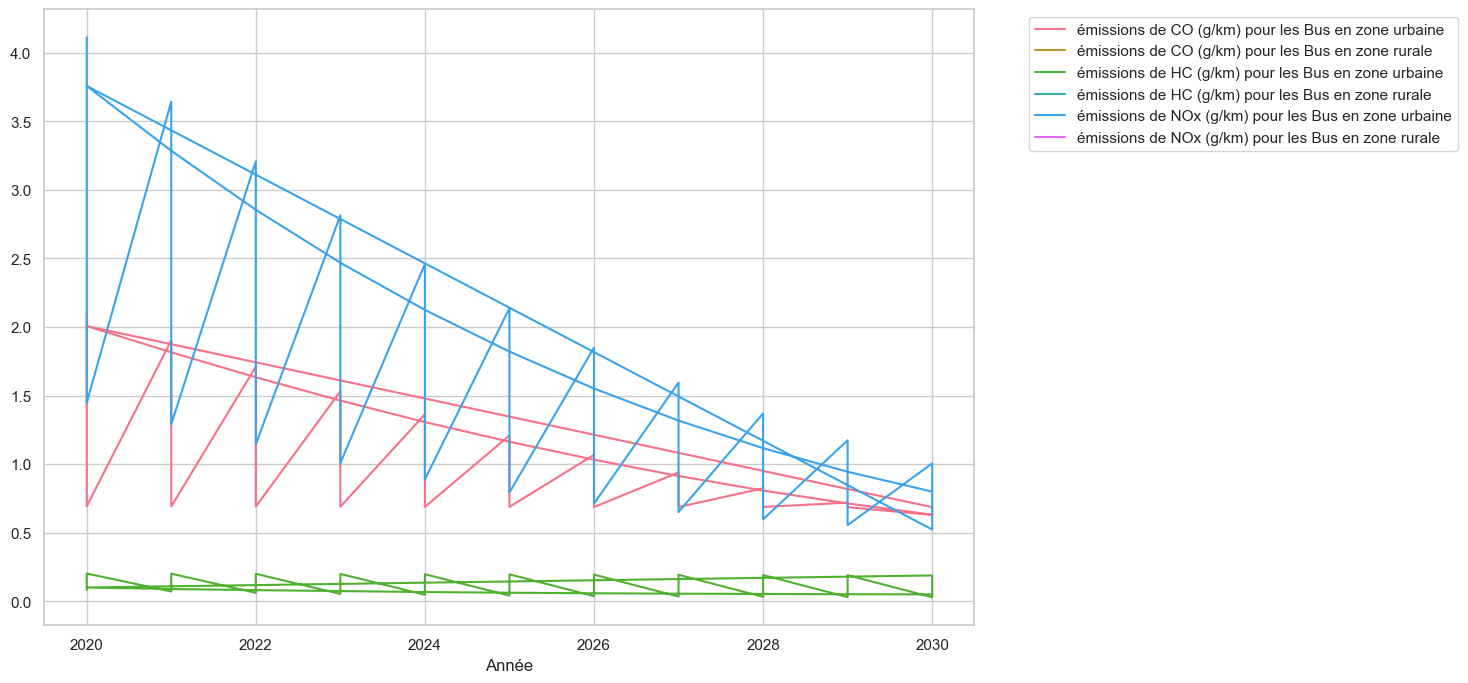

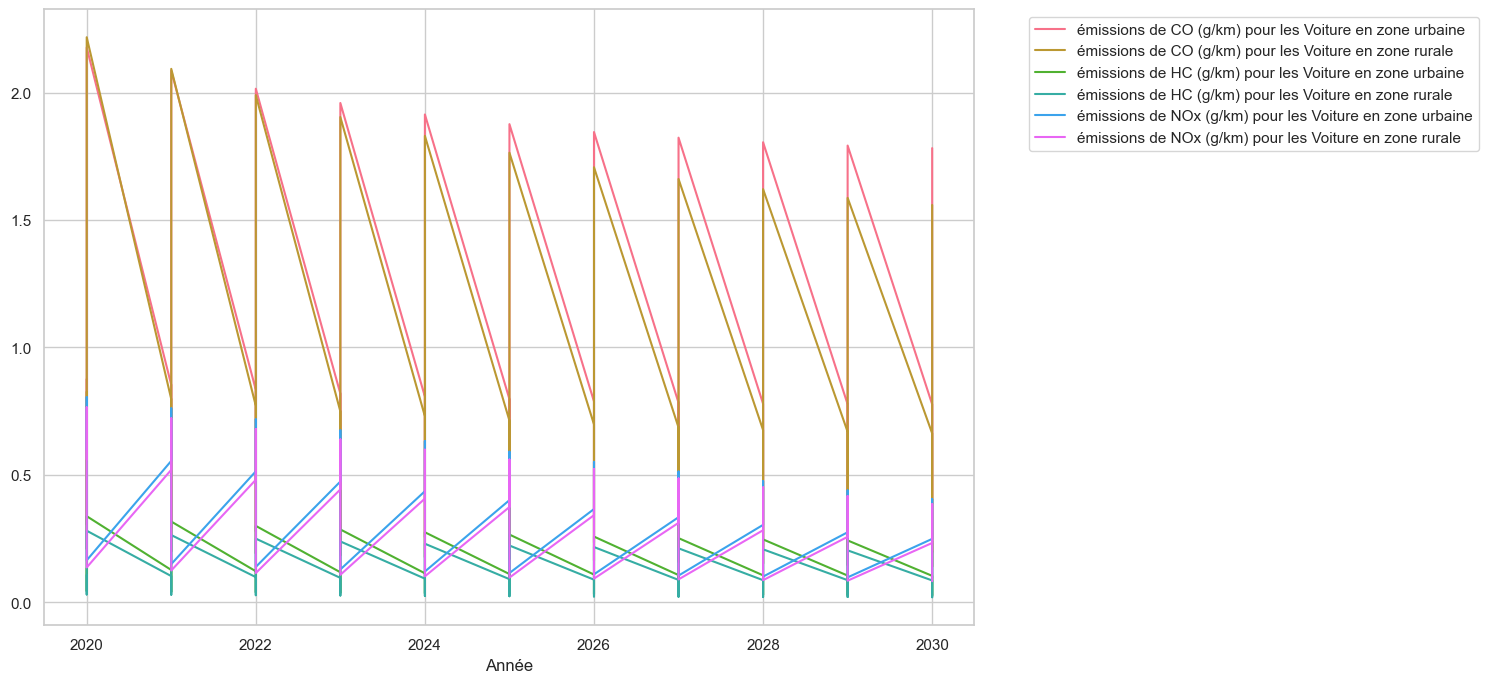

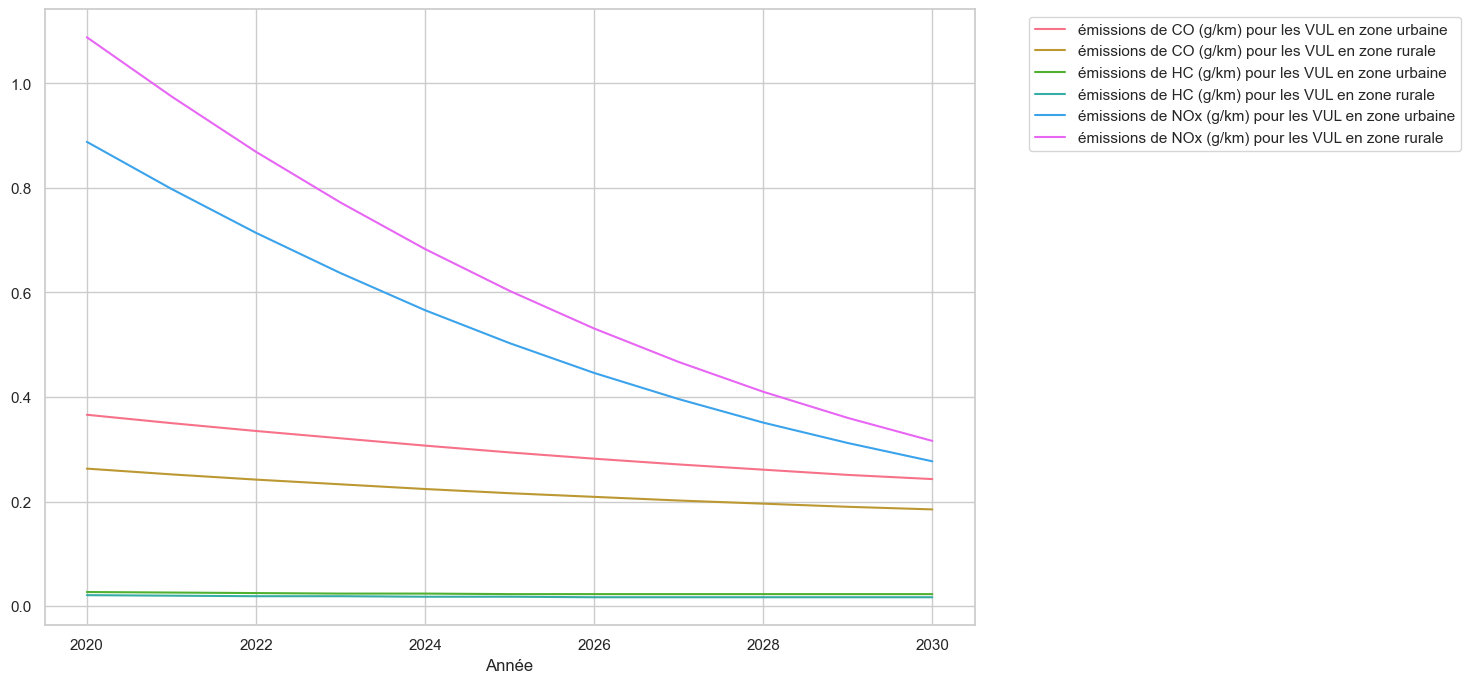

In [13]:
liste_vehicule = ['2RM', 'PL', 'Autocar', 'Bus', 'Voiture', 'VUL']
liste_df = [df[df['Véhicule']==f'{vehicule}'] for vehicule in liste_vehicule]

for i, dataframe in enumerate(liste_df): 
    palette = sns.color_palette("husl", n_colors=6)
    dataframe_urbain = dataframe[dataframe['Roulage']=='Urbain']
    dataframe_rural = dataframe[dataframe['Roulage']=='Rural']
    plt.figure(figsize=(12,8))
    plt.plot(dataframe_urbain['Année'], dataframe_urbain['CO (g/km)'], color = palette[0], 
             label = f"émissions de CO (g/km) pour les {liste_vehicule[i]} en zone urbaine")
    plt.plot(dataframe_rural['Année'], dataframe_rural['CO (g/km)'], color = palette[1], 
             label = f"émissions de CO (g/km) pour les {liste_vehicule[i]} en zone rurale")
    plt.plot(dataframe_urbain['Année'], dataframe_urbain['HC (g/km)'], color = palette[2], 
             label = f"émissions de HC (g/km) pour les {liste_vehicule[i]} en zone urbaine")
    plt.plot(dataframe_rural['Année'], dataframe_rural['HC (g/km)'], color = palette[3], 
             label = f"émissions de HC (g/km) pour les {liste_vehicule[i]} en zone rurale")
    plt.plot(dataframe_urbain['Année'], dataframe_urbain['NOx (g/km)'], color = palette[4], 
             label = f"émissions de NOx (g/km) pour les {liste_vehicule[i]} en zone urbaine")
    plt.plot(dataframe_rural['Année'], dataframe_rural['NOx (g/km)'], color = palette[5], 
             label = f"émissions de NOx (g/km) pour les {liste_vehicule[i]} en zone rurale")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlabel('Année')
    plt.show()

<a name='Répartition_pop'></a>

## **II. Répartition de la population en France métropolitaine**

<a name='Répartition_ve'></a>

## **III. Répartition des véhicules électriques en France métropolitaine**